In [5]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm

In [6]:
key = jax.random.PRNGKey(0)

## 1. Problem
In this notebook we try to find the position and size of a guassian conductivity blob by giving the dirichlet and von-Neumann boundary conditions. We solve the heat equation:

$$
\nabla(k\,\nabla T) = 0
$$

where we set:
$$
k = e^{-(r - \mu)^2/\sigma}
$$
and $\mu$ and $\sigma$ are the parameters to infer.

In [7]:
solver = chb.Solver(N = 50)
xx = solver.xx
yy = solver.yy
grid = solver.grid
dims = (solver.N, solver.N)
mask = np.ones(dims)
mask[1:-1,1:-1] = 0
maskx = np.ones(dims)
maskx[:,1:-1] = 0
masky = np.ones(dims)
masky[1:-1,:] = 0
mask = jnp.array(mask)

mu_init = jnp.array([-0.3,0.3])
sigma_init = jnp.array(0.3) 
k_init = jnp.exp(-((xx - mu_init[0])**2+(yy - mu_init[1])**2) / sigma_init) + 0.1
k_cheby_init = solver.invI @ k_init.flatten()

dirichlet = xx**2 + yy**2
dirichlet *= mask

target_solution = solver.solve(k_cheby_init, dirichlet)

@jax.jit
def get_neumann(solution):
    jx = (solution["dx T"] * solution["k"]).reshape(dims)
    jy = (solution["dy T"] * solution["k"]).reshape(dims)

    neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
    return neumann

@jax.jit
def distance(solution, target_solution):
    neumann = get_neumann(solution)
    target_neumann = get_neumann(target_solution)

    return jnp.sum((neumann- target_neumann)**2)

Text(0.5, 1.0, 'resulting temperature')

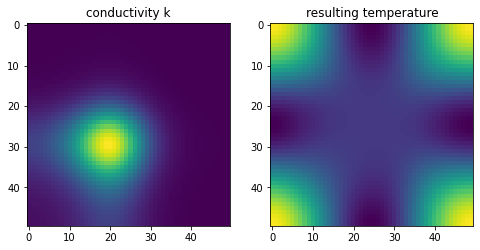

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (8,4))
axs[0].imshow(target_solution["k"].reshape(dims))
axs[0].set_title("conductivity k")
axs[1].imshow(target_solution["T"].reshape(dims))
axs[1].set_title("resulting temperature")

Text(0.5, 1.0, 'Neumann boundary')

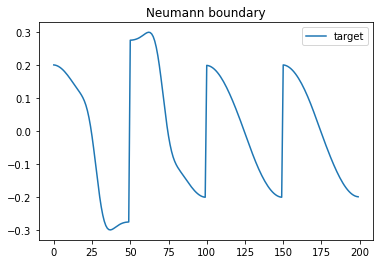

In [9]:
plt.plot(get_neumann(target_solution), label = "target")

plt.legend()
plt.title("Neumann boundary")

## 2. Initialise variational parameters

In [10]:
k_param = {"mu": jax.random.uniform(key, shape = (2,), minval=-0.3, maxval=0.3), "sigma":1.}

In [11]:
@jax.jit
def get_solution(k_param):
    k = jnp.exp(-((xx - k_param["mu"][0])**2+(yy - k_param["mu"][1])**2) / k_param["sigma"]) + 0.1
    k_cheby = solver.invI @ k.flatten()
    solution = solver.solve(k_cheby, dirichlet)
    return solution

## 3. Optimize parameters

In [12]:
@jax.jit
def loss(k_param):
    return distance(get_solution(k_param), target_solution)

g = jax.value_and_grad(loss)

In [24]:
# define
optimizer = optax.adam(learning_rate=0.02)

# initialise
optimizer_state = optimizer.init(k_param)

err = []

In [32]:
for i in tqdm(range(10)):
    val, grad = g(k_param)
    err.append(val)

    updates, optimizer_state = optimizer.update(grad, optimizer_state, k_param)

    k_param = optax.apply_updates(k_param, updates)

100%|██████████| 10/10 [00:55<00:00,  5.57s/it]


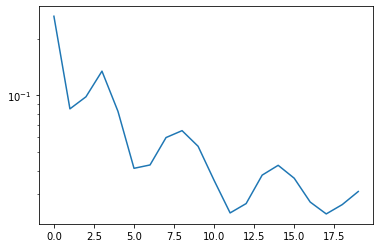

In [33]:
plt.plot(err)
plt.yscale("log")

Text(0.5, 1.0, 'Neumann boundary')

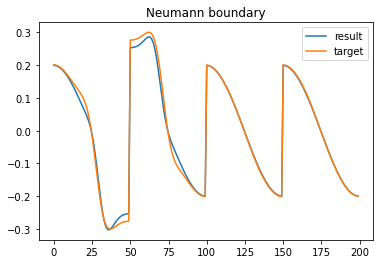

In [34]:
plt.plot(get_neumann(get_solution(k_param)), label = "result")
plt.plot(get_neumann(target_solution), label ="target")

plt.legend()
plt.title("Neumann boundary")

Text(0.5, 1.0, 'resulting temperature')

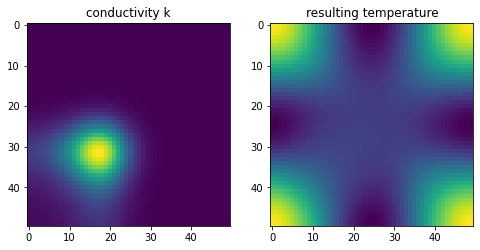

In [35]:
result = get_solution(k_param)
fig, axs = plt.subplots(1, 2, figsize = (8,4))
axs[0].imshow(result["k"].reshape(dims))
axs[0].set_title("conductivity k")
axs[1].imshow(result["T"].reshape(dims))
axs[1].set_title("resulting temperature")

In [36]:
k_param

{'mu': Array([-0.42099191,  0.44897931], dtype=float64),
 'sigma': Array(0.17627819, dtype=float64)}

In [37]:
mu_init

Array([-0.3,  0.3], dtype=float64)

In [38]:
sigma_init

Array(0.3, dtype=float64, weak_type=True)